### Nous allons reprendre le pipeline de classification avec des données sélectionnées avec variété par maladie: articles_selectionnes_par_maladie.csv

Dans ce fichier, nous avons :
- supprimé les articles avec les caractères incompréhensibles,  
- Remplacé les NAN de title par des chaines vides 
- Supprimé les doublons
- Supprimé les noms des maladies 

In [2]:
import pandas as pd 

# Comme nous avions remplacé les titres NAN par des chaines vides, à la sauvegarde ces titres sont
# encore remplacés par des NAN il parait, du coup pour éviter cela nous utilisons l'argument keep_default_na qu'on 
# met à False 
data = pd.read_csv("./data/data_selected_by_disease_phase1_private.csv", keep_default_na=False)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701 entries, 0 to 1700
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           1701 non-null   object
 1   text            1701 non-null   object
 2   Thematique      1701 non-null   object
 3   Maladie         1701 non-null   object
 4   text_sans_html  1701 non-null   object
 5   clean_text      1701 non-null   object
dtypes: object(6)
memory usage: 79.9+ KB


In [3]:
data["Thematique"].value_counts()

Thematique
SV    567
SP    567
SA    567
Name: count, dtype: int64

### Classification 

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Texte nettoyé
X = data["clean_text"]

# 2. Labels encodés
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data["Thematique"])

# 3. Division en train / validation / test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)  # 70% train
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)  # 15% val, 15% test

# 4. Pipeline : TF-IDF + Random Forest
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
])

# 5. Entraînement sur le train
pipeline.fit(X_train, y_train)

# 6. Évaluation sur le val
y_pred = pipeline.predict(X_val)
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

          SA       0.97      0.87      0.92        85
          SP       0.86      0.98      0.92        85
          SV       1.00      0.98      0.99        85

    accuracy                           0.94       255
   macro avg       0.95      0.94      0.94       255
weighted avg       0.95      0.94      0.94       255



In [5]:
# 6. Évaluation sur le test
y_pred = pipeline.predict(X_test)
print("Evaluation sur les données de test")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Evaluation sur les données de test
              precision    recall  f1-score   support

          SA       0.99      0.79      0.88        85
          SP       0.82      0.99      0.89        85
          SV       1.00      0.99      0.99        86

    accuracy                           0.92       256
   macro avg       0.93      0.92      0.92       256
weighted avg       0.93      0.92      0.92       256



### Essayons de voir la matrice de confusion sur les ensembles de validation et de test

<Figure size 800x600 with 0 Axes>

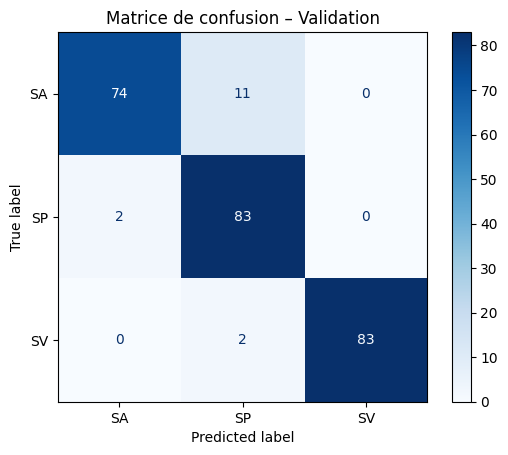

<Figure size 800x600 with 0 Axes>

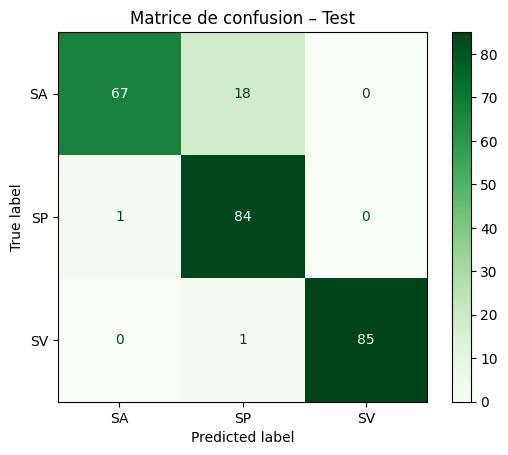

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === PRÉDICTIONS ===
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

# === MATRICE DE CONFUSION VALIDATION ===
cm_val = confusion_matrix(y_val, y_pred_val)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=label_encoder.classes_)

plt.figure(figsize=(8, 6))
disp_val.plot(cmap='Blues', values_format='d')
plt.title("Matrice de confusion – Validation")
plt.show()

# === MATRICE DE CONFUSION TEST ===
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_encoder.classes_)

plt.figure(figsize=(8, 6))
disp_test.plot(cmap='Greens', values_format='d')
plt.title("Matrice de confusion – Test")
plt.show()


### Calcul de l'auc

In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Prédire les probabilités pour la première classe comme nous en avaons 2
y_proba = pipeline.predict_proba(X_test)


# Étape 3 : calcul de l’AUC (one-vs-rest)
auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')

print(f"AUC (macro-averaged, ovr): {auc:.4f}")


AUC (macro-averaged, ovr): 0.9819


#### Visualisons la répartion des maladies dans les ensembles train, validation et test maintenant pour voir 

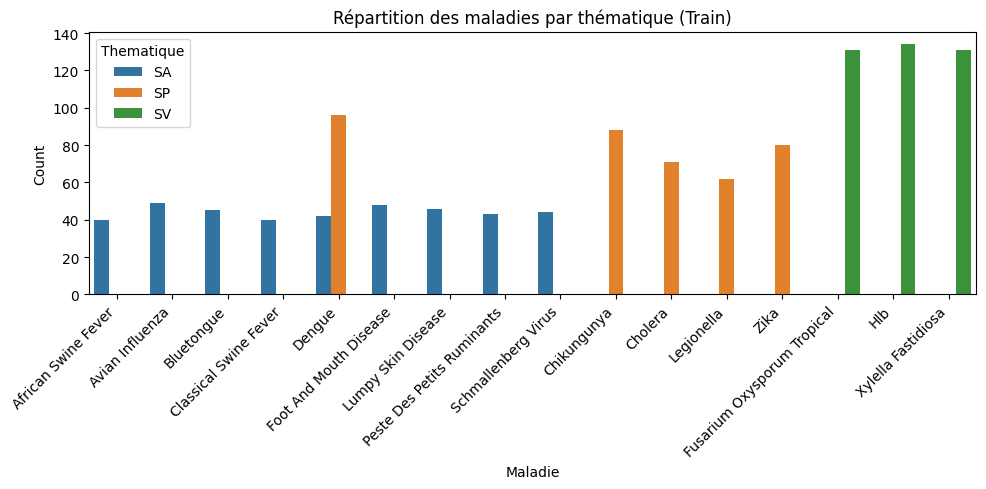

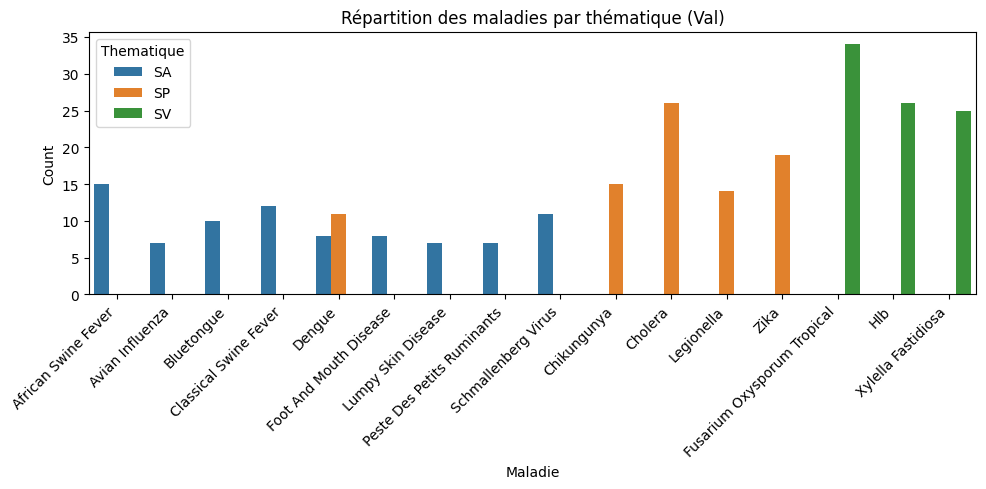

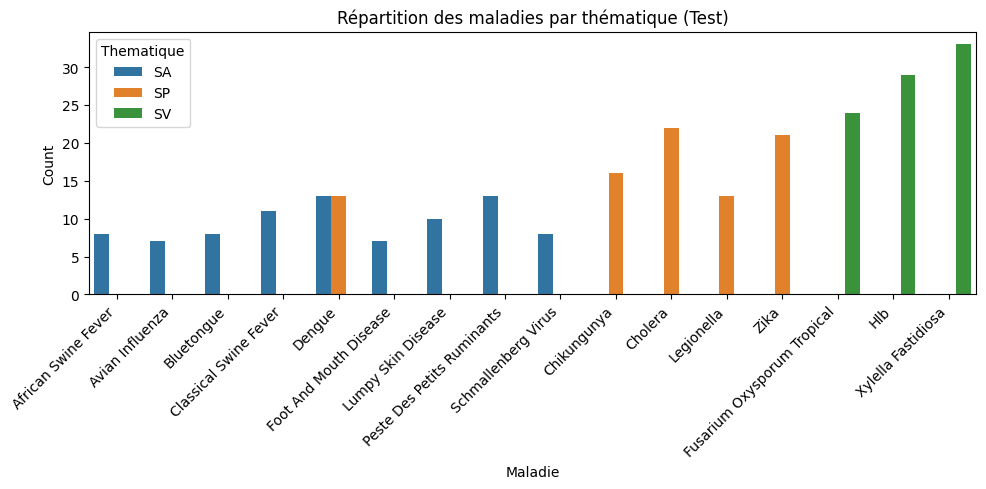

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Création de la colonne Set pour savoir dans quel split chaque article tombe
data_final_split = data.copy()
data_final_split["Set"] = "Train"
data_final_split.loc[X_val.index, "Set"] = "Val"
data_final_split.loc[X_test.index, "Set"] = "Test"

# Grouper par Set, Thematique et Maladie
grouped = data_final_split.groupby(["Set", "Thematique", "Maladie"]).size().reset_index(name="Count")

# On affiche un histogramme pour chaque ensemble (train, val, test)
for split in ["Train", "Val", "Test"]:
    plt.figure(figsize=(10, 5))
    subset = grouped[grouped["Set"] == split]
    
    sns.barplot(data=subset, x="Maladie", y="Count", hue="Thematique")
    plt.title(f"Répartition des maladies par thématique ({split})")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


### Sauvegarde de ce deuxième modèle 

In [11]:
import joblib

# Sauvegarde du pipeline complet
joblib.dump(pipeline, './models/modele_thematique_maladie.pkl')


['./models/modele_thematique_maladie.pkl']

In [12]:
import joblib

# Chargement du modèle 
pipeline = joblib.load('./models/modele_thematique_maladie.pkl')

# Texte à prédire
texte = ["A new disease affecting animals was discovered this year."]

# Prédiction
pred = pipeline.predict(texte)
pred_label = label_encoder.inverse_transform(pred)[0]

# Probabilités associées
probas = pipeline.predict_proba(texte)[0]  # tableau 1D des proba pour chaque classe

# Affichage
print(f"Texte : {texte[0]}")
print(f"Thématique prédite : {pred_label}")
print("Probabilités par classe :")
for i, p in enumerate(probas):
    print(f"  {label_encoder.classes_[i]} : {p:.4f}")


Texte : A new disease affecting animals was discovered this year.
Thématique prédite : SV
Probabilités par classe :
  SA : 0.2900
  SP : 0.0550
  SV : 0.6550


### Appliquons SBERT puis une classification avec Random Forest

In [18]:
## Vectorisation sbert, nous utilisons la version légère qui a d'ailleur donné de bon résultats

from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer("all-MiniLM-L6-v2")  
texts = data["clean_text"]

X_sbert = sbert_model.encode(texts, show_progress_bar=True)

/home/rosalie/miniforge3/envs/sursy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rosalie/miniforge3/envs/sursy/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 54/54 [00:01<00:00, 28.82it/s]


In [19]:

# Entraînement d’un RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Encodage des labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data["Thematique"])

# Split
X_train, X_test, y_train, y_test = train_test_split(X_sbert, y, test_size=0.2, random_state=42, stratify=y)

# RandomForest
clf = RandomForestClassifier(n_estimators=400, random_state=42) # Plusieurs valeurs de n_estimators testées, ceci semble mieux fonctionner 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Rapport
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

          SA       0.99      0.81      0.89       113
          SP       0.84      0.98      0.90       114
          SV       0.98      0.99      0.99       114

    accuracy                           0.93       341
   macro avg       0.94      0.93      0.93       341
weighted avg       0.94      0.93      0.93       341



### Calcul de l'auc 

In [20]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Prédire les probabilités pour la première classe comme nous en avaons 2
y_proba = clf.predict_proba(X_test)


# Étape 3 : calcul de l’AUC (one-vs-rest)
auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')

print(f"AUC (macro-averaged, ovr): {auc:.4f}")


AUC (macro-averaged, ovr): 0.9824


### Sauvegarde du modèle 

In [21]:
import joblib

# Sauvegarde du model 
joblib.dump(clf, './models/modele_thematique_SBERT_maladie.pkl')


['./models/modele_thematique_SBERT_maladie.pkl']

#### Exemple de prédiction pour une phrase 

In [22]:
from sentence_transformers import SentenceTransformer
import joblib

# 1. Charger le modèle SBERT qu'on a utilisé à l'entrainement 
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')  # ou le modèle que tu avais utilisé

# 2. Charger le modèle de classification
model = joblib.load('./models/modele_thematique_SBERT_maladie.pkl')

# 3. Texte à prédire
texte = ["A new disease affecting animals was discovered this year"]

# 4. Vectorisation avec SBERT
texte_vect = sbert_model.encode(texte)

# 5. Prédiction
pred = model.predict(texte_vect)
pred_label = label_encoder.inverse_transform(pred)[0]

# 6. Probabilités associées
probas = model.predict_proba(texte_vect)[0]

# 7. Affichage
print("Prédiction avec le modèle SBERT+RandomForest sur la deuxième version des données")
print(f"Texte : {texte[0]}")
print(f"Thématique prédite : {pred_label}")
print("Probabilités par classe :")
for i, p in enumerate(probas):
    print(f"  {label_encoder.classes_[i]} : {p:.4f}")


/home/rosalie/miniforge3/envs/sursy/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Prédiction avec le modèle SBERT+RandomForest sur la deuxième version des données
Texte : A new disease affecting animals was discovered this year
Thématique prédite : SA
Probabilités par classe :
  SA : 0.6200
  SP : 0.2025
  SV : 0.1775


### Appliquons maitenant l'apprentissage par transfert: les embeddings de SBERT sont fournis au perceptron multicouche simple que nous définissons aussi 

In [25]:
### Les librairies 
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sentence_transformers import SentenceTransformer
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import classification_report
%load_ext memory_profiler


In [26]:
# Créer une colonne combinée titre + texte
data["titre_texte"] = data["title"].fillna('') + " " + data["text"].fillna('')

# Détection des doublons sur cette combinaison
doublons_combines = data.duplicated(subset=["titre_texte"])
print(f"Doublons sur la combinaison titre + texte : {doublons_combines.sum()}")


Doublons sur la combinaison titre + texte : 0


In [27]:
texts = data["clean_text"].astype(str).tolist()
labels = data["Thematique"].astype(str)

In [28]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

In [29]:
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [30]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
X_train_embed = sbert_model.encode(X_train, convert_to_tensor=True, show_progress_bar=True)
X_val_embed = sbert_model.encode(X_val, convert_to_tensor=True, show_progress_bar=True)
X_test_embed = sbert_model.encode(X_test, convert_to_tensor=True, show_progress_bar=True)


/home/rosalie/miniforge3/envs/sursy/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 8/8 [00:00<00:00, 49.83it/s]


In [31]:
train_dataset = TensorDataset(X_train_embed, torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(X_val_embed, torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(X_test_embed, torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [32]:
class SBERTClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(SBERTClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SBERTClassifier(X_train_embed.shape[1], len(label_encoder.classes_)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [33]:
import numpy as np
import torch

save_path = "./models/best_sbert_model_maladie.pt"
best_val_loss = np.inf
patience = 5
patience_counter = 0

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "train_f1": [], "val_f1": []}
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    y_true_train, y_pred_train, train_loss = [], [], 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        y_true_train.extend(y_batch.cpu().numpy())
        y_pred_train.extend(preds.cpu().numpy())

    train_loss /= len(train_loader)
    train_acc = accuracy_score(y_true_train, y_pred_train)
    train_f1 = f1_score(y_true_train, y_pred_train, average='macro')

    # Validation
    model.eval()
    y_true_val, y_pred_val, val_loss = [], [], 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            y_true_val.extend(y_batch.cpu().numpy())
            y_pred_val.extend(preds.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = accuracy_score(y_true_val, y_pred_val)
    val_f1 = f1_score(y_true_val, y_pred_val, average='macro')

    # Stockage
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)

    print(f"[{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

    # Sauvegarde du meilleur modèle
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping déclenché.")
            break

# Rechargement du meilleur modèle
model.load_state_dict(torch.load(save_path))
print("Meilleur modèle chargé (val_loss minimum :", round(best_val_loss, 4), ")")


[1/100] Train Loss: 1.0862 | Val Loss: 1.0728 | Train Acc: 0.5076 | Val Acc: 0.6549 | Train F1: 0.4217 | Val F1: 0.5733
[2/100] Train Loss: 1.0583 | Val Loss: 1.0415 | Train Acc: 0.7361 | Val Acc: 0.8431 | Train F1: 0.7074 | Val F1: 0.8386
[3/100] Train Loss: 1.0195 | Val Loss: 0.9979 | Train Acc: 0.8529 | Val Acc: 0.8824 | Train F1: 0.8491 | Val F1: 0.8810
[4/100] Train Loss: 0.9703 | Val Loss: 0.9451 | Train Acc: 0.8950 | Val Acc: 0.8941 | Train F1: 0.8941 | Val F1: 0.8937
[5/100] Train Loss: 0.9133 | Val Loss: 0.8858 | Train Acc: 0.9084 | Val Acc: 0.8980 | Train F1: 0.9080 | Val F1: 0.8980
[6/100] Train Loss: 0.8498 | Val Loss: 0.8215 | Train Acc: 0.9193 | Val Acc: 0.9176 | Train F1: 0.9190 | Val F1: 0.9180
[7/100] Train Loss: 0.7784 | Val Loss: 0.7565 | Train Acc: 0.9227 | Val Acc: 0.9137 | Train F1: 0.9225 | Val F1: 0.9138
[8/100] Train Loss: 0.7192 | Val Loss: 0.6947 | Train Acc: 0.9218 | Val Acc: 0.9216 | Train F1: 0.9215 | Val F1: 0.9218
[9/100] Train Loss: 0.6586 | Val Loss: 0

/tmp/ipykernel_2930342/4198993208.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


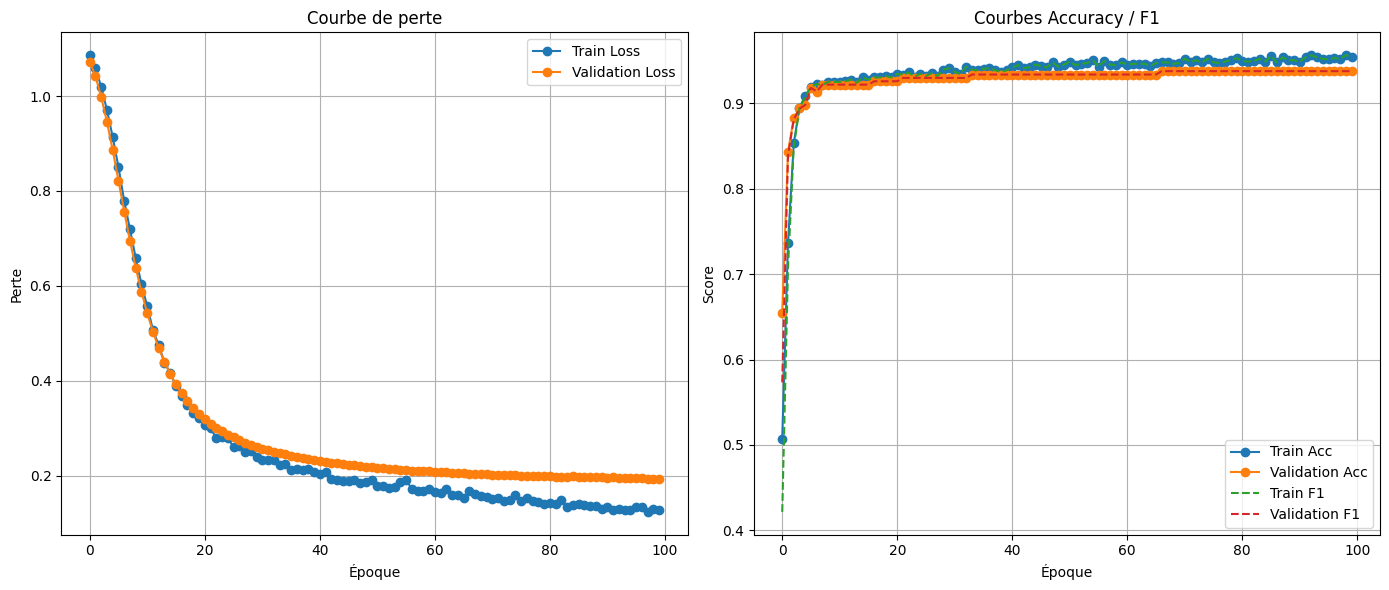

In [34]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss", marker="o")
plt.plot(history["val_loss"], label="Validation Loss", marker="o")
plt.title("Courbe de perte")
plt.xlabel("Époque")
plt.ylabel("Perte")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc", marker="o")
plt.plot(history["val_acc"], label="Validation Acc", marker="o")
plt.plot(history["train_f1"], label="Train F1", linestyle="--")
plt.plot(history["val_f1"], label="Validation F1", linestyle="--")
plt.title("Courbes Accuracy / F1")
plt.xlabel("Époque")
plt.ylabel("Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [35]:
model.eval()
y_test_true, y_test_pred = [], []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        preds = torch.argmax(outputs, dim=1)
        y_test_true.extend(y_batch.numpy())
        y_test_pred.extend(preds.cpu().numpy())

test_acc = accuracy_score(y_test_true, y_test_pred)
test_f1 = f1_score(y_test_true, y_test_pred, average='macro')
print("\nÉvaluation finale sur les données de test")
print("Accuracy :", round(test_acc, 4))
print("Macro F1 :", round(test_f1, 4))
print("\nClassification Report :")
print(classification_report(y_test_true, y_test_pred, target_names=label_encoder.classes_))


Évaluation finale sur les données de test
Accuracy : 0.9336
Macro F1 : 0.9331

Classification Report :
              precision    recall  f1-score   support

          SA       0.96      0.84      0.89        85
          SP       0.85      0.96      0.91        85
          SV       1.00      1.00      1.00        86

    accuracy                           0.93       256
   macro avg       0.94      0.93      0.93       256
weighted avg       0.94      0.93      0.93       256



In [36]:
import torch
import torch.nn as nn

class SBERTClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(SBERTClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)


# Recréer le modèle avec les bons paramètres
input_dim = 384  # SBERT 'all-MiniLM-L6-v2' size
num_classes = 3  
model = SBERTClassifier(input_dim, num_classes)
model.load_state_dict(torch.load("./models/best_sbert_model_maladie.pt"))
model.eval()


/tmp/ipykernel_2930342/983847303.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/best_sbert_model_maladie.pt"))


SBERTClassifier(
  (classifier): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [39]:
import numpy as np
import torch
from sentence_transformers import SentenceTransformer

# Aligne le device sur celui du classifieur 'model'
_device = next(model.parameters()).device
_dtype  = next(model.parameters()).dtype

# Charge SBERT et place-le sur le même device
sbert_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
sbert_model.to(_device)

def predict_thematique(text: str):
    """Prédit la thématique à partir de l'embedding SBERT passé dans ton classifieur linéaire."""
    model.eval()
    sbert_model.eval()

    with torch.no_grad():
        # 1) Embedding SBERT sur le même device
        emb = sbert_model.encode(
            [text],
            convert_to_tensor=True,
            device=str(_device),          # s'assure du même device
            normalize_embeddings=False
        )
        # 2) Assure le même dtype que le classifieur (souvent float32)
        emb = emb.to(device=_device, dtype=_dtype)   # (1, dim)

        # 3) Logits -> Probabilités
        logits = model(emb)              # shape (1, num_labels)
        if isinstance(logits, (tuple, list)):
            logits = logits[0]
        probs = torch.softmax(logits, dim=-1).squeeze(0).float().cpu().numpy()

    pred_idx = int(np.argmax(probs))
    predicted_label = label_encoder.inverse_transform([pred_idx])[0]
    confidence = float(probs[pred_idx])

    # Affichage lisible
    print(f"Texte : {text}")
    print(f"Thématique prédite : {predicted_label}")
    print(f"Score de confiance : {confidence:.4f}")
    print("\nProbabilités par classe :")
    for idx, p in enumerate(probs):
        lbl = label_encoder.inverse_transform([idx])[0]
        print(f"  {lbl} : {p:.4f}")

    return predicted_label, confidence


/home/rosalie/miniforge3/envs/sursy/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [40]:
predict_thematique("A new disease affecting animals was discovered this year")


Texte : A new disease affecting animals was discovered this year
Thématique prédite : SA
Score de confiance : 0.9967

Probabilités par classe :
  SA : 0.9967
  SP : 0.0028
  SV : 0.0005


('SA', 0.996684730052948)

### Calcul auc et affichage de la courbe d'apprentissage 

In [42]:
import numpy as np
import torch

# Aligne device et dtype sur le classifieur
device = next(model.parameters()).device
dtype  = next(model.parameters()).dtype

model.eval()
y_true, y_probs = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        # --- 1) Prépare X selon son format ---
        if isinstance(xb, dict):
            # Cas "tokenizer HF": xb est un dict input_ids/attention_mask/...
            xb = {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in xb.items()}
            out = model(**xb)
            logits = out.logits if hasattr(out, "logits") else out[0]
        else:
            # Cas "embeddings (Tensor) ou ndarray"
            if torch.is_tensor(xb):
                xb = xb.to(device=device, dtype=dtype)
            else:
                xb = torch.tensor(xb, device=device, dtype=dtype)
            out = model(xb)
            logits = out if torch.is_tensor(out) else out[0]

        # --- 2) Probas ---
        probs = torch.softmax(logits, dim=-1).float().cpu().numpy()  # (batch, n_classes)
        y_probs.append(probs)

        # --- 3) Labels ---
        if torch.is_tensor(yb):
            yb = yb.detach().cpu().numpy()
        else:
            yb = np.asarray(yb)
        y_true.append(yb)

# Empile correctement
y_probs = np.vstack(y_probs)              # (N, n_classes)
y_true  = np.concatenate(y_true).astype(int)  # (N,)


In [43]:
from sklearn.preprocessing import label_binarize

# Exemple : 3 classes
n_classes = len(label_encoder.classes_)
y_true_bin = label_binarize(y_true, classes=range(n_classes))


In [44]:
from sklearn.metrics import roc_auc_score

# AUC macro
auc_macro = roc_auc_score(y_true_bin, y_probs, average="macro", multi_class="ovr")

# AUC weighted (optionnel)
auc_weighted = roc_auc_score(y_true_bin, y_probs, average="weighted", multi_class="ovr")

print(f"AUC Macro     : {auc_macro:.4f}")
print(f"AUC Weighted  : {auc_weighted:.4f}")


AUC Macro     : 0.9920
AUC Weighted  : 0.9920


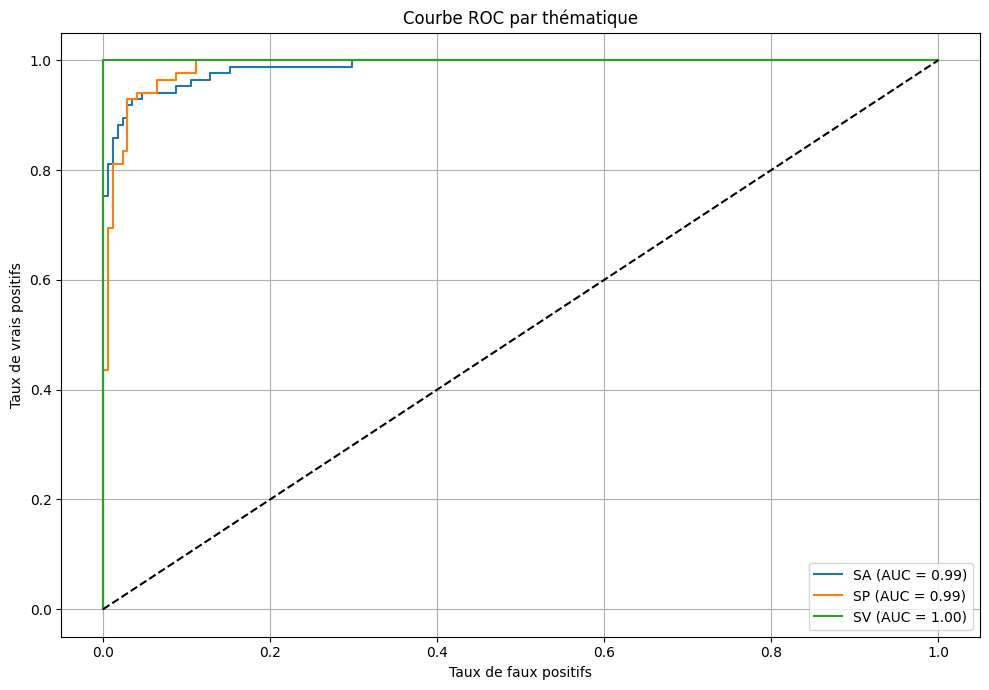

In [45]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()

# Récupération des noms de classes
class_names = label_encoder.classes_

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer la courbe ROC par thématique
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC par thématique")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Sauvegardons les librairies ainsi que les versions que nous avons utilisées ici à la phase 1

In [46]:
!pip freeze > requirements.txt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
